# Prevalence and Efficacy of Moderation

In this notebook, we explore the prevalance and efficacy of methods for moderating personal attacks on Wikipedia.

#### Background on Moderation

There is an explict [policy](https://en.wikipedia.org/wiki/Wikipedia:Policies_and_guidelines) on Wikipedia against making [personal attacks](https://en.wikipedia.org/wiki/Wikipedia:No_personal_attacks). Any user who observes or experiences a personal attack can place a standardized warning message on the offending user's talk page via a set of [templates](https://en.wikipedia.org/wiki/Template:Uw-npa1). In these tamplates, users have the option to cite the page on which the attack occured, but they generally do not cite the actual revision where the attack was introduced.

In addition to warnings, Wikipedia administrators have the ability to suspend the editing rights of users who violate the policy on personal attacks. This action is known as blocking a user. The duration and extent of the block is variable and at the discretion of the administrator. The interface admins use for blocking users requires providing a reason for the block. The reasons generally come from a small set of choices from a drop down list and map to the different Wikipedia policies. We are only interested in blocks where the admin selected the "[[WP:No personal attacks|Personal attacks]()] or [[WP:Harassment|harassment]()]" reason. Note that there is a seperate policy on Wikipedia against [harassment](https://en.wikipedia.org/wiki/Wikipedia:Harassment), which encompasses behaviors such as legal threats and posting personal information, which we do not address in this study. Unfortunatly, admins generally do to cite the page or revision the indcident occured on when blocking a user.  Administrators tend to block users in response to personal attacks reported on the [Administrators Noticeboard](https://en.wikipedia.org/wiki/Wikipedia:Administrators%27_noticeboard/Incidents) for incidents, but it is also not uncommon for them to block users in response to attacks they observe during their other activities. Finally, administrators have the ability to delete the revision containing the attack from public view. Note that we only work with comments that have not been deleted.

#### Data

In order to get data on warnings, we generated a dataset of all public user talk page diffs, identified the diffs that contained a warning and parsed the information in the template. From the template we can extract the following information:
- the user name of the user posting the warning
- the user name of the user being warned
- the timestamp of the warning
- the page the attack occured on (not always given)


Data on block events comes from the public logging table. Each record provides:
- the user name of the admin
- the user name of the user being blocked
- the timestamp of the block event (this is not the timestamp of the attack)
Again, we only block events with the "[[WP:No personal attacks|Personal attacks]()] or [[WP:Harassment|harassment]()]" reason.

We also ran our machine learning model for detecting personal attacks on two dataset of comments (diffs)
- every user and article talk comment made in 2015
- every user and article talk comment made by a user blocked for personal attacks



#### Analysis


- Summary stats of warnings and blocks
    - How often do they occur?
    - How many individuals have been blocked/warned?
    - Temporal Trends
    - How often do warnings result in blocks?

- How do blocked users behave after being blocked?
    - Will they be blocked again?
    - Are new attacks from blocked users more likely to lead to a block?

- What are the "politics" of blocking a user?
    - Are anons more likely to be blocked?
    - Are long term editors less likely to be blocked?

- How comprehensive is the moderation?
    - What fraction of attacking users have been blocked for harassment?
    - What fraction of attacking comments come from users blocked for harassment?
    - What fraction of attacking comments were followed by a block event?
    - How does the probability of a user being blocked change with the number of attacking comments?
    
Note: interesting interplay between ground truth data, that comes from Wikipedia community itself, but that may be incomplete and the ML scores which are based on evaluations from people outside community, are a bit noisy, but are totally comprehensive.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *

In [2]:
d = load_diffs()
df_block_events, df_blocked_user_text = load_block_events_and_users()
df_warn_events, df_warned_user_text = load_warn_events_and_users()

In [70]:
moderated_users = [('warned', df_warned_user_text), ('blocked', df_blocked_user_text)]
moderation_events = [('warned', df_warn_events), ('blocked', df_block_events)]

## Summary stats of warnings and blocks


In [33]:
print('# block events: %s' % df_block_events.shape[0])

print('# warn events: %s' % df_warn_events.shape[0])


# block events: 27343
# warn events: 36520


There have been 27343 instances of a user being blocked and 36520 instances of a user being warned for personal attacks in the history of Wikipedia. Warnings have different levels and most are of the form "if you continue to attack users, you may be blocked", so we expect there to be a large difference. However, we will dig deeper into the relationship between warning and blocking later.

In [37]:
print('# block events')
print(df_block_events.groupby('anon').size())
print()
print('# warn events')
print(df_warn_events.groupby('anon').size())

# block events
anon
False    12377
True     14966
dtype: int64

# warn events
anon
False    18263
True     18257
dtype: int64


Almost half of all block events involved the blocking of an anonymous user. Half of warn events were addressed to anons. We need to do some more work here to understand if anons or registered users are disproportionatley blocked. 

In [39]:
print('# blocked users')
print(df_block_events.groupby('anon').user_text.nunique())
print()
print('# warned users')
print(df_warn_events.groupby('anon').user_text.nunique())

# blocked users
anon
False    10106
True     13562
Name: user_text, dtype: int64

# warned users
anon
False    13624
True     15283
Name: user_text, dtype: int64


In [40]:
print('fraction of blocked users with a public user talk comment')
print(d['blocked'].groupby('author_anon').user_text.nunique() / df_block_events.groupby('anon').user_text.nunique())

fraction of blocked users with a public user talk comment
author_anon
False    0.606966
True     0.511871
Name: user_text, dtype: float64


Only 55% of users blocked have a public comment in the user or talk ns. This can be because users can get blocked for personal attacks for comments they make in the main ns and because the revisions can be made private.

### Q: How many users got blocked multiple times?

In [41]:
df_block_events.assign(block_count = 1)\
.groupby(['user_text', 'anon'], as_index = False)['block_count'].sum()\
.groupby(['anon', 'block_count']).size()

anon   block_count
False  1               8568
       2               1135
       3                235
       4                 91
       5                 42
       6                 16
       7                  8
       8                  5
       9                  3
       10                 1
       15                 1
       16                 1
True   1              12416
       2                964
       3                136
       4                 32
       5                  5
       6                  5
       7                  3
       10                 1
dtype: int64

The vast majority of blocked users only get blocked once. Note that blocks are usually not indefinite but result in a temprory supension of certain editing rights. Unsurprisingly, registered users are more likley to be reblocked than anons.

### Q: How are the counts changing from year to year

Note: there is no month pattern and the hourly pattern just tells you when enforcement happens, not when the attacks happen.

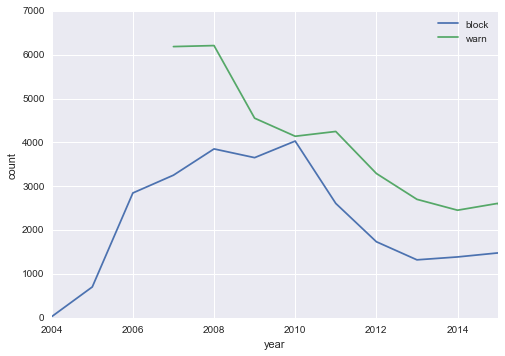

In [42]:
df_block_events.year.value_counts().sort_index().plot(label = 'block')
df_warn_events.year.value_counts().sort_index().plot(label = 'warn')
plt.xlabel('year')
plt.ylabel('count')
plt.xlim((2004, 2015))
plt.legend()

It looks like the warning template was intorduced in 2007. The number of block events per year looks a lot like the graph of participation in Wikipedia per year, although there has been a slight uptick in recent years. 

### Q: How often do warnings result in blocks? How often where blocks preceded by warnings?


In [55]:
b = set(df_blocked_user_text['user_text'])
w = set(df_warned_user_text['user_text'])
len(w.intersection(b)) / len(w)

0.11464351195212233

Only 11% warned users have been blocked. Lets also, check what fraction of blocked users ever got warned. This is a bit tricky since our group of blocked userd includes uers who were blocked for harassmnet, which is quite different.

In [173]:
len(w.intersection(b)) / len(b)

0.1400202805475748

A first estimate gives that, 14% of blocked users have been warned. This is probably an underestimate because the set of blocked user contains harasseres that may not have made a personal attack. We can also check what fraction of blocked users, who have made an attack that our algorithm detected, have been warned.

In [118]:
a = set(d['blocked'].query('pred_recipient_score > 0.7')['user_text'])
len(a.intersection(b).intersection(w)) / len(a.intersection(b))

0.3087760493102436

31% of blocked editors that our model confirmed made a personal attack where warned before hand.

In conlusion, we see that warning and blocking are fairly different mechanisms. Most people who get warned do not get blocked and most people who get blocked do not get warned. It seems like it would provide transparency to the moderation process if there was a clearer policy.

# How do blocked users behave after being blocked?

### Q:  Will they be blocked again? P(blocked again | blocked at least k times)

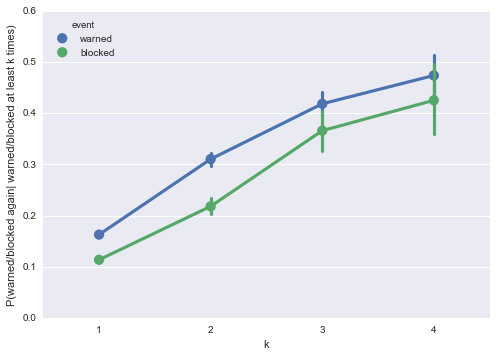

In [71]:
dfs = []

for k in range(1, 5):
    for event, data in moderation_events:
        df_k = data.assign(blocked = 1)\
                .groupby('user_text', as_index = False)['blocked'].sum()\
                .query('blocked >=%f'%k)
        df_k1 = data.assign(blocked = 1)\
                .groupby('user_text', as_index = False)['blocked'].sum()\
                .query('blocked >=%f'%(k+1))\
                .assign(again = 1)
        df = df_k.merge(df_k1, how = 'left', on = 'user_text')\
                .assign(again = lambda x: x.again.fillna(0))\
                .assign(k=k, event = event)
        dfs.append(df)

sns.pointplot(x = 'k', y = 'again', hue = 'event', data = pd.concat(dfs))
plt.xlabel('k')
plt.ylabel('P(warned/blocked again| warned/blocked at least k times)')

Every time a user get blocked, the chance that they will get blocked again increases. This could be explained by the fact that there is some set of persistently toxic users, who keep coming back after being blocked, while the less persistent ones get discouraged by the blocks. It may also be that being blocked tends to lead to more toxic behaviour. We might be able to tell the difference by using a matching experiment.

### Q: Are new attacks from blocked users more likely to lead to a block? P(blocked | attacked and blocked k times already)

The methodology for this is a bit involved. 

- events[i]: the set of ith block events per user
- blocked_users[i] = set of users blocked i times, e.g. set of users in events[i]
- attacks[i]: the set of attacks made by users after their ith block, excluding comments made after their (i+1)th block, if it happened.
- attackers[i]: set of users in attacks[i]
- P(blocked | attacked and blocked k times already): $$ \frac{|blocked[k+1] \cap attackers[k]|}{|attackers[k]|}$$

In [157]:
K = 6
sample = 'blocked'
threshold = 0.5

In [158]:
events = {}

# null events set
e = d[sample][['user_text']].drop_duplicates()
e['timestamp'] = pd.to_datetime('1900')
events[0] = e

# rank block events
ranked_events = df_block_events.copy()
ranks = df_block_events\
.groupby('user_text')['timestamp']\
.rank()
ranked_events['rank'] = ranks

for k in range(1,K):
    e = ranked_events.query("rank==%d" % k)[['user_text', 'timestamp']]
    events[k] = e

In [159]:
attacks = {}
for k in range(0, K-1):
    c = d[sample].merge(events[k], how = 'inner', on='user_text')
    c = c.query('timestamp < rev_timestamp')
    del c['timestamp']
    c = c.merge(events[k+1], how = 'left', on = 'user_text')
    c['timestamp'] = c['timestamp'].fillna(pd.to_datetime('2100'))
    c = c.query('rev_timestamp < timestamp')
    c = c.query('pred_recipient_score > %f' % threshold)
    attacks[k] = c

In [163]:
blocked_users = {i:set(events[i]['user_text']) for i in events.keys()}
attackers = {i:set(attacks[i]['user_text']) for i in attacks.keys()}

In [169]:
dfs_sns = []

for k in range(1, K-1):
    u_a = attackers[k]
    u_b = blocked_users[k+1]
    u_ab = u_a.intersection(u_b)
    n_a = len(u_a)
    n_ab = len(u_ab)
    print('k:',k,  n_ab/n_a)
    
    dfs_sns.append(pd.DataFrame({'blocked': [1]*n_ab, 'k': [k]*n_ab}))
    dfs_sns.append(pd.DataFrame({'blocked': [0]*(n_a- n_ab), 'k': [k]*(n_a- n_ab)}))

k: 1 0.3153786104605777
k: 2 0.46303501945525294
k: 3 0.5360824742268041
k: 4 0.6410256410256411


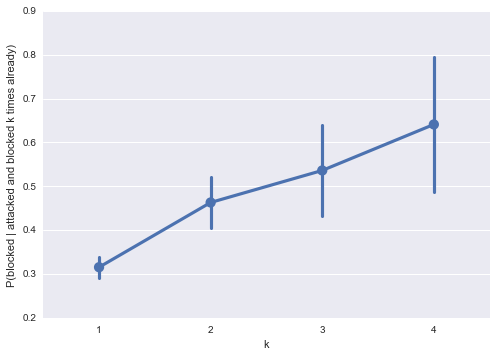

In [172]:
sns.pointplot(x = 'k', y = 'blocked', data = pd.concat(dfs_sns))
plt.xlabel('k')
plt.ylabel('P(blocked | attacked and blocked k times already)')

The probability of making a personal attack and subsequently being blocked increases as a function of how many times the user has been blocked before. This could indicate heightened scrutiny by administrators. The pattern could also occur if users who continue to attack after being blocked make more frequent or more toxic attacks.  Again, we should think about some sort of matching experiment.

# What are the "politics" of blocking a user?

### Q: Are anons more likely to be blocked?

Controlling for attack probability, are anons more likely to be moderated?

In [208]:
dfs = []
step = 0.2
ts = np.arange(0.4, 0.81, step)
moderated_users = [('warn', df_warned_user_text), ('blocked', df_blocked_user_text)]

for t in ts:
    for (event_type, users) in moderated_users:
        dfs.append(\
                    d['2015'].query('pred_recipient_score >= %f and pred_recipient_score <= %f' % (t, t+step))\
                    [['user_text', 'author_anon']]\
                    .drop_duplicates()\
                    .merge(users, how = 'left', on = 'user_text')\
                    .assign(blocked = lambda x: x.blocked.fillna(0),
                            threshold = t, event = event_type )
                   )
                 
               
df = pd.concat(dfs)
df['author_anon']=df['author_anon'].astype(str)


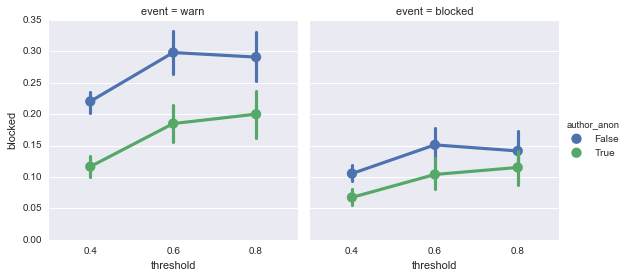

In [212]:
g = sns.factorplot(x="threshold", y="blocked", hue="author_anon", col="event", data=df, hue_order=["False", "True"])

Anons are less likely to be blocked and warned! That is not what I expected.

### Q: Are long term editors less likely to be blocked?

Compute block/warn prob in 2015 as a function of how many days they were active before Jan 1 2015. 

In [ ]:
attackers = d['2015'].query('not author_anon and pred_recipient_score > 0.7')[['user_text']].drop_duplicates()

In [270]:
# get days active
d_tenure = pd.read_csv('../../data/long_term_users.tsv', sep = '\t')
d_tenure.columns = ['user_text', 'n']
attackers = attackers.merge(d_tenure, how = 'left', on = 'user_text')
attackers['n'] = attackers['n'].fillna(0)

In [276]:
# bin days active
tresholds = np.percentile(attackers['n'],  np.arange(0, 100.01,10 ))
tresholds = sorted(set(tresholds.astype(int)))
bins = []
for i in range(len(tresholds)-1):
    label = '%d-%d' % (tresholds[i], tresholds[i+1]-1)
    rnge = range(tresholds[i], tresholds[i+1])
    bins.append((label, rnge))
    
def map_count(x):
    for label, rnge in bins:
        if x in rnge:
            return label
attackers['binned_n'] = attackers['n'].apply(map_count)

In [ ]:
# get if blocked
blocked_users_2015 = df_block_events.query("timestamp > '2014-12-31'")[['user_text']].drop_duplicates()
blocked_users_2015['blocked'] = 1
attackers = attackers.merge(blocked_users_2015, how='left', on='user_text')
attackers['blocked'] = attackers['blocked'].fillna(0)

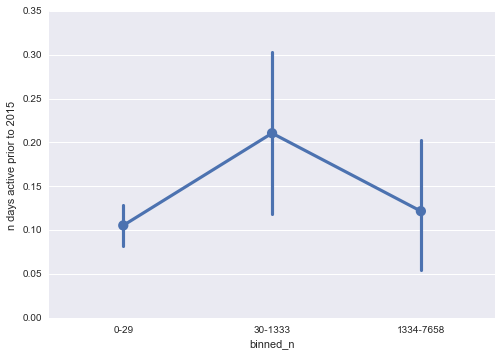

In [278]:
#plot
o = [e[0] for e in bins]
sns.pointplot(x='binned_n', y = 'blocked', data=attackers, order = o)
plt.ylabel('P(blocked in 2015| attacked in 2915)')
plt.ylabel('n days active prior to 2015')

# How comprehensive is the moderation?


### Q: What fraction of attacking users have been warned/blocked for harassment?

Take unsampled data from 2015. Label a user as attacking if one of their comments is above the threshold. Join list of blocked users to see if any of them have ever or will ever be blocked.

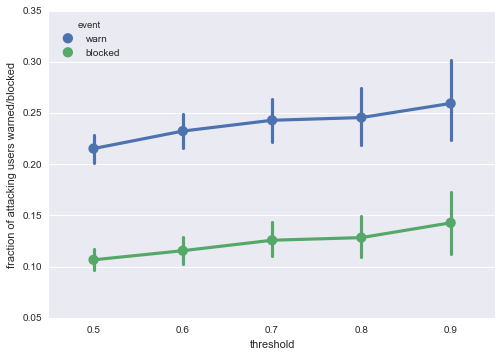

In [72]:
dfs = []
ts = np.arange(0.5, 0.91, 0.1)
moderated_users = [('warn', df_warned_user_text), ('blocked', df_blocked_user_text)]

for t in ts:
    for (event_type, users) in moderated_users:
        dfs.append(\
                    d['2015'].query('pred_recipient_score >= %f' % t)[['user_text', 'author_anon']]\
                    .drop_duplicates()\
                    .merge(users, how = 'left', on = 'user_text')\
                    .assign(blocked = lambda x: x.blocked.fillna(0),
                            threshold = t, event = event_type )
                   )
                 
               
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', hue='event', data = df)
plt.ylabel('fraction of attacking users warned/blocked')
plt.savefig('../../paper/figs/fraction_of_attacking_users_warned_and_blocked.png')

Most users who have made at least one attack have never been warned or blocked.

### Q: What fraction of attacking comments were followed by a warn or block event?
Within one week

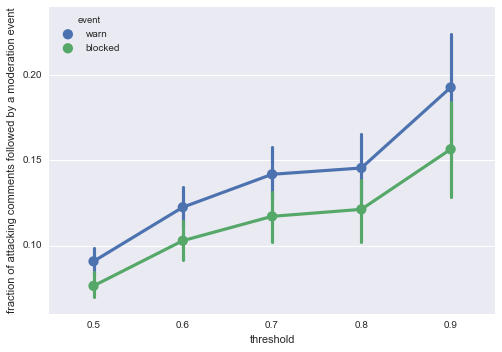

In [6]:
dfs = []
ts = np.arange(0.5, 0.91, 0.1)
moderation_events = [('warn', df_warn_events), ('blocked', df_block_events)]


def get_delta(x):
    if x['timestamp'] is not None and x['rev_timestamp'] is not None:
        return x['timestamp'] - x['rev_timestamp']
    else:
        return pd.Timedelta('0 seconds') 
    
for t in ts:
    for (event_type, events) in moderation_events:
        dfs.append(
                    d['2015'].query('pred_recipient_score >= %f' % t)\
                            .loc[:, ['user_text', 'rev_id', 'rev_timestamp']]\
                            .merge(events, how = 'left', on = 'user_text')\
                            .assign(delta = lambda x: get_delta(x))\
                            .assign(blocked= lambda x: (x['delta'] <  pd.Timedelta('7 days')) & (x['delta'] >  pd.Timedelta('0 seconds')))\
                            .drop_duplicates(subset = ['rev_id'])\
                            .assign(threshold = t, event=event_type)
                    )
ax = sns.pointplot(x='threshold', y='blocked', hue='event', data = pd.concat(dfs))
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments followed by a moderation event')

Most attacking comments do not lead to the user being warned/blocked within the next 7 days.

### Q: What fraction of attacking comments come from users warned/blocked for harassment?

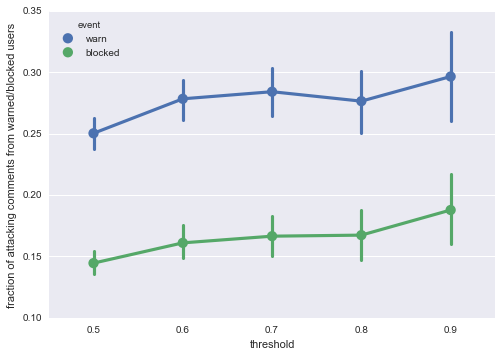

In [12]:
dfs = []


for t in ts:
    for event_type, users in moderated_users:
        dfs.append(\
                    d['2015'].query('pred_recipient_score >= %f' % t)\
                    .merge(users, how = 'left', on = 'user_text')\
                    .assign(blocked = lambda x: x.blocked.fillna(0),
                            threshold = t, event = event_type)
                   )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', hue = 'event', data = df)
plt.ylabel('fraction of attacking comments from warned/blocked users')

Most attacks do not come from people who have never been warned/blocked for harassment.

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

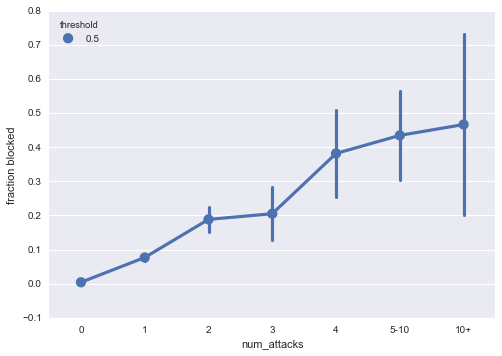

In [15]:
def remap(x):
    if x < 5:
        return str(int(x))
    if x < 10:
        return '5-10'
    else:
        return '10+'
    
t = 0.5 

        
d_temp = d['2015'].assign(attack = lambda x: x.pred_recipient_score >=  t)\
                .groupby('user_text', as_index = False)['attack'].sum()\
                .rename(columns={'attack':'num_attacks'})\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(
                    blocked = lambda x: x.blocked.fillna(0,),
                    num_attacks = lambda x: x.num_attacks.apply(remap),
                    threshold = t)
                
ax = sns.pointplot(x='num_attacks', y= 'blocked', data=d_temp, hue = 'threshold', order = ('0', '1', '2', '3', '4', '5-10', '10+'))
plt.ylabel('fraction blocked')

The more attacks a user makes, the more likely it is that they will have been blocked at least once.